Unsupervised Anomaly Detection in Cloud Network Traffic

In [28]:
import pandas as pd

# Specify the folder containing Parquet files
folder_path = 'raw_data'

# Read all Parquet files in the folder into a single DataFrame
df = pd.read_parquet(folder_path)

# Verify the data
print(df.shape)
print(df.head())

(81677, 22)
    timestamp                                              event session_id  \
0  1593556826  {"data":"AAAAhf9TTUJyAAAAABhTwAAAAAAAAAAAAAAAA...   JmMVgAho   
1  1593556825  {"data":"","encrypted":false,"key":"","lsh":"0...   OHshp0CX   
2  1593556825  {"data":"AwAALyrgAAAAAABDb29raWU6IG1zdHNoYXNoP...   eY28t725   
3  1593556822  {"data":"UE9TVCAvd3MvdjEvY2x1c3Rlci9hcHBzL25ld...   qrJldKNm   
4  1593556822  {"data":"SFRUUC8xLjAgNDAwIEJhZCBSZXF1ZXN0DQpTZ...   qrJldKNm   

   source_port  destination_port       source_ip       sensor_ip  \
0        64032               445   218.21.102.59  162.209.99.210   
1        53000             16595  198.199.115.94   34.243.244.50   
2         1048              3301   92.63.194.102    54.186.51.14   
3        56480              8088  64.227.103.233  54.213.169.194   
4        56480              8088  64.227.103.233  54.213.169.194   

   destination_ip meta_type                            event_uuid  ...  \
0  162.209.99.210  response  2

Preprocessing

checking for missing values

In [32]:
missing_percent = df.isnull().mean() * 100
print(missing_percent)

timestamp           0.0
event               0.0
session_id          0.0
source_port         0.0
destination_port    0.0
source_ip           0.0
sensor_ip           0.0
destination_ip      0.0
meta_type           0.0
event_uuid          0.0
sensor_uuid         0.0
hostname            0.0
project             0.0
provider            0.0
region              0.0
protocol            0.0
app_protocol        0.0
3wh                 0.0
ip_version          0.0
metadata            0.0
vpn                 0.0
vpn_service         0.0
dtype: float64


In [34]:
df.dtypes

timestamp            int32
event               object
session_id          object
source_port          int64
destination_port     int32
source_ip           object
sensor_ip           object
destination_ip      object
meta_type           object
event_uuid          object
sensor_uuid         object
hostname            object
project             object
provider            object
region              object
protocol            object
app_protocol        object
3wh                   bool
ip_version           int32
metadata            object
vpn                   bool
vpn_service         object
dtype: object

In [36]:
df.rename(columns={'region':'org_region'},inplace=True)

In [38]:
df.columns

Index(['timestamp', 'event', 'session_id', 'source_port', 'destination_port',
       'source_ip', 'sensor_ip', 'destination_ip', 'meta_type', 'event_uuid',
       'sensor_uuid', 'hostname', 'project', 'provider', 'org_region',
       'protocol', 'app_protocol', '3wh', 'ip_version', 'metadata', 'vpn',
       'vpn_service'],
      dtype='object')

Handling python dictionary type column -' metadata'

In [41]:
df['metadata'].head()

0    {'category': 'isp', 'city': 'Hangzhou', 'domai...
1    {'category': 'hosting', 'city': 'San Francisco...
2    {'category': 'hosting', 'city': 'Sarapul', 'do...
3    {'category': 'hosting', 'city': 'Santa Clara',...
4    {'category': 'hosting', 'city': 'Santa Clara',...
Name: metadata, dtype: object

In [43]:
# Expand the 'metadata' column into separate columns
df_metadata = df['metadata'].apply(pd.Series)
df_metadata.head()


,category,city,domain,mobile,country,region,long,tor,rdns_validated,country_code,lat,org,postal,type,asn,datacenter,rdns_parent,rdns,url,phone
0,isp,Hangzhou,gx163.net,False,China,Zhejiang,120.1614,False,False,CN,30.2936,CHINANET-BACKBONE,NaN,isp,AS4134,None,None,None,None,None
1,hosting,San Francisco,digitalocean.com,False,United States,California,-122.3886,False,False,US,37.7309,"DigitalOcean, LLC",94124.0,hosting,AS14061,DigitalOcean USA,None,None,None,None
2,hosting,Sarapul,reliabledata.com,False,Russia,Udmurtiya Republic,53.7978,False,False,RU,56.4763,Chelyshev Sergej Aleksandrovich,427960.0,hosting,AS48817,None,None,None,None,None
3,hosting,Santa Clara,digitalocean.com,False,United States,California,-121.9623,False,False,US,37.3924,"DigitalOcean, LLC",95054.0,hosting,AS14061,PEER 1,None,None,None,None
4,hosting,Santa Clara,digitalocean.com,False,United States,California,-121.9623,False,False,US,37.3924,"DigitalOcean, LLC",95054.0,hosting,AS14061,PEER 1,None,None,None,None


In [44]:
# Concatenate with the original DataFrame
df = pd.concat([df.drop(columns='metadata'), df_metadata], axis=1)

df.head()

,timestamp,event,session_id,source_port,destination_port,source_ip,sensor_ip,destination_ip,meta_type,event_uuid,...,lat,org,postal,type,asn,datacenter,rdns_parent,rdns,url,phone
0,1593556826,"{""data"":""AAAAhf9TTUJyAAAAABhTwAAAAAAAAAAAAAAAA...",JmMVgAho,64032,445,218.21.102.59,162.209.99.210,162.209.99.210,response,272a108d-65cc-4ad6-b443-9e56d7e52ade,...,30.2936,CHINANET-BACKBONE,NaN,isp,AS4134,None,None,None,None,None
1,1593556825,"{""data"":"""",""encrypted"":false,""key"":"""",""lsh"":""0...",OHshp0CX,53000,16595,198.199.115.94,34.243.244.50,172.31.18.61,response,01e109d4-9d7c-4e8f-b749-13bb40d86af4,...,37.7309,"DigitalOcean, LLC",94124.0,hosting,AS14061,DigitalOcean USA,None,None,None,None
2,1593556825,"{""data"":""AwAALyrgAAAAAABDb29raWU6IG1zdHNoYXNoP...",eY28t725,1048,3301,92.63.194.102,54.186.51.14,172.31.3.118,response,e18d5887-ecf7-44a8-835f-16fff39fff94,...,56.4763,Chelyshev Sergej Aleksandrovich,427960.0,hosting,AS48817,None,None,None,None,None
3,1593556822,"{""data"":""UE9TVCAvd3MvdjEvY2x1c3Rlci9hcHBzL25ld...",qrJldKNm,56480,8088,64.227.103.233,54.213.169.194,172.31.4.128,response,5d9f6ad0-9f64-4005-bea8-71d4067d00e7,...,37.3924,"DigitalOcean, LLC",95054.0,hosting,AS14061,PEER 1,None,None,None,None
4,1593556822,"{""data"":""SFRUUC8xLjAgNDAwIEJhZCBSZXF1ZXN0DQpTZ...",qrJldKNm,56480,8088,64.227.103.233,54.213.169.194,172.31.4.128,persona,19197f9e-f33e-45bc-bca0-c33dbf42b7a3,...,37.3924,"DigitalOcean, LLC",95054.0,hosting,AS14061,PEER 1,None,None,None,None


In [45]:
df.shape

(81677, 41)

Handling 'event' column- json strings

In [50]:
# Convert JSON strings to dictionaries
import json
df['event'] = df['event'].apply(json.loads)

# Normalize the 'event' column
event_df = pd.json_normalize(df['event'])
event_df.head()


,data,encrypted,key,lsh,rtt,size,timeout,xxh
0,AAAAhf9TTUJyAAAAABhTwAAAAAAAAAAAAAAAAAAA//4AAE...,False,,69d09b6775501c55e4b18170c677436344254c78e720a4...,0,137,False,4d3b36cbacd9182a
1,,False,,07d0000000000000c00000300000000000000000000000...,0,0,False,ef46db3751d8e999
2,AwAALyrgAAAAAABDb29raWU6IG1zdHNoYXNoPUFkbWluaX...,False,,65d00210746a3f54c28545b01544d6488414886851959f...,0,47,False,4783d9b323134ca3
3,UE9TVCAvd3MvdjEvY2x1c3Rlci9hcHBzL25ldy1hcHBsaW...,False,,91d095b6195214f34f41f2ade5a4f1f500b7e812a1c55b...,0,251,False,368a71869049b05d
4,SFRUUC8xLjAgNDAwIEJhZCBSZXF1ZXN0DQpTZXJ2ZXI6IE...,False,,a2d0a767520b358ac711d3750ec1b51025b40b84a75b14...,0,251,False,afa33bcb952bf5b


In [51]:
# Concatenate with the original DataFrame
df1 = pd.concat([df.drop(columns='event'), event_df], axis=1)
df1.head()


,timestamp,session_id,source_port,destination_port,source_ip,sensor_ip,destination_ip,meta_type,event_uuid,sensor_uuid,...,url,phone,data,encrypted,key,lsh,rtt,size,timeout,xxh
0,1593556826,JmMVgAho,64032,445,218.21.102.59,162.209.99.210,162.209.99.210,response,272a108d-65cc-4ad6-b443-9e56d7e52ade,52c9d053-72ca-c3d9-ac2e-61703645363b,...,None,None,AAAAhf9TTUJyAAAAABhTwAAAAAAAAAAAAAAAAAAA//4AAE...,False,,69d09b6775501c55e4b18170c677436344254c78e720a4...,0,137,False,4d3b36cbacd9182a
1,1593556825,OHshp0CX,53000,16595,198.199.115.94,34.243.244.50,172.31.18.61,response,01e109d4-9d7c-4e8f-b749-13bb40d86af4,c1646eb2-edc4-dc8d-67f4-f5505dbb08a5,...,None,None,,False,,07d0000000000000c00000300000000000000000000000...,0,0,False,ef46db3751d8e999
2,1593556825,eY28t725,1048,3301,92.63.194.102,54.186.51.14,172.31.3.118,response,e18d5887-ecf7-44a8-835f-16fff39fff94,9efc3c5b-3c02-10a5-2341-6bf5d4d73d81,...,None,None,AwAALyrgAAAAAABDb29raWU6IG1zdHNoYXNoPUFkbWluaX...,False,,65d00210746a3f54c28545b01544d6488414886851959f...,0,47,False,4783d9b323134ca3
3,1593556822,qrJldKNm,56480,8088,64.227.103.233,54.213.169.194,172.31.4.128,response,5d9f6ad0-9f64-4005-bea8-71d4067d00e7,5cd5a48d-a217-f130-253d-dd74d0d79168,...,None,None,UE9TVCAvd3MvdjEvY2x1c3Rlci9hcHBzL25ldy1hcHBsaW...,False,,91d095b6195214f34f41f2ade5a4f1f500b7e812a1c55b...,0,251,False,368a71869049b05d
4,1593556822,qrJldKNm,56480,8088,64.227.103.233,54.213.169.194,172.31.4.128,persona,19197f9e-f33e-45bc-bca0-c33dbf42b7a3,5cd5a48d-a217-f130-253d-dd74d0d79168,...,None,None,SFRUUC8xLjAgNDAwIEJhZCBSZXF1ZXN0DQpTZXJ2ZXI6IE...,False,,a2d0a767520b358ac711d3750ec1b51025b40b84a75b14...,0,251,False,afa33bcb952bf5b


checking unique values in each column

In [55]:
df1.nunique()

timestamp            4252
session_id          67943
source_port         30944
destination_port     3890
source_ip            3381
sensor_ip              57
destination_ip         58
meta_type               2
event_uuid          68676
sensor_uuid            57
hostname               57
project                 1
provider                4
org_region             31
protocol                2
app_protocol           10
3wh                     2
ip_version              1
vpn                     2
vpn_service             5
category                5
city                 1013
domain                925
mobile                  2
country               111
region                571
long                 1052
tor                     2
rdns_validated          1
country_code          111
lat                  1052
org                   826
postal                604
type                    4
asn                   875
datacenter             55
rdns_parent           568
rdns                 1387
url         

In [57]:
df1.columns

Index(['timestamp', 'session_id', 'source_port', 'destination_port',
       'source_ip', 'sensor_ip', 'destination_ip', 'meta_type', 'event_uuid',
       'sensor_uuid', 'hostname', 'project', 'provider', 'org_region',
       'protocol', 'app_protocol', '3wh', 'ip_version', 'vpn', 'vpn_service',
       'category', 'city', 'domain', 'mobile', 'country', 'region', 'long',
       'tor', 'rdns_validated', 'country_code', 'lat', 'org', 'postal', 'type',
       'asn', 'datacenter', 'rdns_parent', 'rdns', 'url', 'phone', 'data',
       'encrypted', 'key', 'lsh', 'rtt', 'size', 'timeout', 'xxh'],
      dtype='object')

code-df.get_dummies()- got crashed---therefore finding unique values in each of columns(categorical/object)

droping identity columns, columns with single unique values

In [61]:
# List of columns to drop
columns_to_drop = [ 'session_id', 'source_ip','sensor_ip','event_uuid','sensor_uuid','country','long','lat','region','timestamp','destination_ip','project','rtt','rdns_validated','country_code']  

# Drop the columns
df1_dropped = df1.drop(columns=columns_to_drop)

# Check the shape of the DataFrame after dropping the columns
print(f"Shape after dropping columns: {df1_dropped.shape}")


Shape after dropping columns: (81677, 33)


saving cleaned data

In [38]:
!pip install pandas pyarrow

In [40]:
df1_dropped.to_parquet('cleaned_data.parquet', engine='pyarrow')

OHE (One hot encoding)

In [63]:
# Identify categorical columns (replace with actual column names)
categorical_columns = df1_dropped.select_dtypes(include=['object', 'category']).columns.tolist()

#OHE on categorical columns
df_ohe = pd.get_dummies(df1_dropped, columns=categorical_columns, sparse=True,drop_first=True)

In [45]:
missing_percent = df_ohe.isnull().mean() * 100
print(missing_percent)

C:\Users\marod\AppData\Local\Temp\ipykernel_25564\613066841.py:1: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  missing_percent = df_ohe.isnull().mean() * 100


source_port             0.0
destination_port        0.0
3wh                     0.0
ip_version              0.0
vpn                     0.0
                       ... 
xxh_ffdf8f2ec7e2f9bc    0.0
xxh_ffdfd9445cc59616    0.0
xxh_ffe958928910086a    0.0
xxh_ffedf0c1bbae7ca9    0.0
xxh_fff97373979a915e    0.0
Length: 27600, dtype: Sparse[float64, 0.0]


In [46]:
df_ohe.columns

Index(['source_port', 'destination_port', '3wh', 'ip_version', 'vpn', 'mobile',
       'tor', 'postal', 'encrypted', 'size',
       ...
       'xxh_ffb34ee128f45bec', 'xxh_ffc290e4420d37e4', 'xxh_ffc427eeab26ae40',
       'xxh_ffc84e68e26ae524', 'xxh_ffd1dd33e30f7f08', 'xxh_ffdf8f2ec7e2f9bc',
       'xxh_ffdfd9445cc59616', 'xxh_ffe958928910086a', 'xxh_ffedf0c1bbae7ca9',
       'xxh_fff97373979a915e'],
      dtype='object', length=27600)

In [65]:
# Make a copy to avoid modifying the original DataFrame
df_dense = df_ohe.copy()

# Convert only sparse columns to dense
for col in df_dense.columns:
    if isinstance(df_dense[col].dtype, pd.SparseDtype):  # Check if column is sparse
        df_dense[col] = df_dense[col].sparse.to_dense()  # Convert to dense


In [66]:
df_dense.dtypes

source_port             int64
destination_port        int32
3wh                      bool
ip_version              int32
vpn                      bool
                        ...  
xxh_ffdf8f2ec7e2f9bc     bool
xxh_ffdfd9445cc59616     bool
xxh_ffe958928910086a     bool
xxh_ffedf0c1bbae7ca9     bool
xxh_fff97373979a915e     bool
Length: 27600, dtype: object

In [67]:
df_dense.shape

(81677, 27600)

In [68]:
df_dense.columns

Index(['source_port', 'destination_port', '3wh', 'ip_version', 'vpn', 'mobile',
       'tor', 'postal', 'encrypted', 'size',
       ...
       'xxh_ffb34ee128f45bec', 'xxh_ffc290e4420d37e4', 'xxh_ffc427eeab26ae40',
       'xxh_ffc84e68e26ae524', 'xxh_ffd1dd33e30f7f08', 'xxh_ffdf8f2ec7e2f9bc',
       'xxh_ffdfd9445cc59616', 'xxh_ffe958928910086a', 'xxh_ffedf0c1bbae7ca9',
       'xxh_fff97373979a915e'],
      dtype='object', length=27600)

In [69]:
df_dense.head()

,source_port,destination_port,3wh,ip_version,vpn,mobile,tor,postal,encrypted,size,...,xxh_ffb34ee128f45bec,xxh_ffc290e4420d37e4,xxh_ffc427eeab26ae40,xxh_ffc84e68e26ae524,xxh_ffd1dd33e30f7f08,xxh_ffdf8f2ec7e2f9bc,xxh_ffdfd9445cc59616,xxh_ffe958928910086a,xxh_ffedf0c1bbae7ca9,xxh_fff97373979a915e
0,64032,445,True,4,False,False,False,NaN,False,137,...,False,False,False,False,False,False,False,False,False,False
1,53000,16595,True,4,False,False,False,94124.0,False,0,...,False,False,False,False,False,False,False,False,False,False
2,1048,3301,True,4,False,False,False,427960.0,False,47,...,False,False,False,False,False,False,False,False,False,False
3,56480,8088,True,4,False,False,False,95054.0,False,251,...,False,False,False,False,False,False,False,False,False,False
4,56480,8088,False,4,False,False,False,95054.0,False,251,...,False,False,False,False,False,False,False,False,False,False


removing duplicate columns

In [71]:
df_dense = df_dense.loc[:, ~df_dense.columns.duplicated()]

In [72]:
df_dense.columns

Index(['source_port', 'destination_port', '3wh', 'ip_version', 'vpn', 'mobile',
       'tor', 'postal', 'encrypted', 'size',
       ...
       'xxh_ffb34ee128f45bec', 'xxh_ffc290e4420d37e4', 'xxh_ffc427eeab26ae40',
       'xxh_ffc84e68e26ae524', 'xxh_ffd1dd33e30f7f08', 'xxh_ffdf8f2ec7e2f9bc',
       'xxh_ffdfd9445cc59616', 'xxh_ffe958928910086a', 'xxh_ffedf0c1bbae7ca9',
       'xxh_fff97373979a915e'],
      dtype='object', length=27600)

In [73]:
df_dense.shape

(81677, 27600)

combining ohe categorical columns and numerical columns

In [74]:
#Select numerical columns
numerical_df = df1_dropped.select_dtypes(include=['number'])
numerical_df.columns

Index(['source_port', 'destination_port', 'ip_version', 'postal', 'size'], dtype='object')

In [75]:
df_combined = pd.concat([df_dense, numerical_df], axis=1)

# Print the combined DataFrame
print(df_combined.head())

   source_port  destination_port    3wh  ip_version    vpn  mobile    tor  \
0        64032               445   True           4  False   False  False   
1        53000             16595   True           4  False   False  False   
2         1048              3301   True           4  False   False  False   
3        56480              8088   True           4  False   False  False   
4        56480              8088  False           4  False   False  False   

     postal  encrypted  size  ...  xxh_ffdf8f2ec7e2f9bc  xxh_ffdfd9445cc59616  \
0       NaN      False   137  ...                 False                 False   
1   94124.0      False     0  ...                 False                 False   
2  427960.0      False    47  ...                 False                 False   
3   95054.0      False   251  ...                 False                 False   
4   95054.0      False   251  ...                 False                 False   

   xxh_ffe958928910086a  xxh_ffedf0c1bbae7ca9  xxh

In [63]:
df_cleaned = df_combined.dropna()

In [64]:
df_cleaned.shape

(57115, 27600)

Model Training

standardizing

In [74]:
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(df_cleaned) # standardization

PCA-to check data is linearly separable

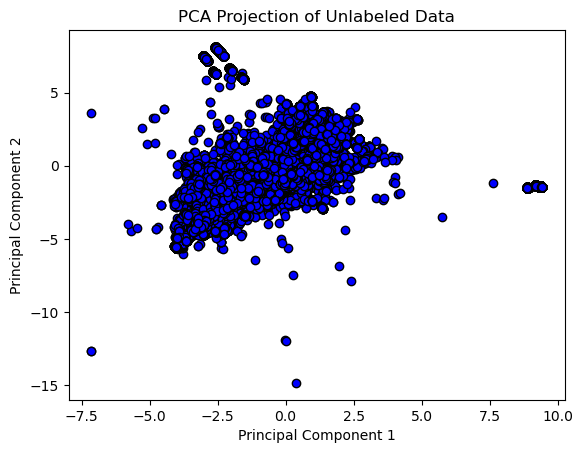

In [76]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.scatter(X_pca[:, 0], X_pca[:, 1], color='blue', edgecolors='k')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection of Unlabeled Data")
plt.show()

# 1. DBSCAN

using knee method to find eps

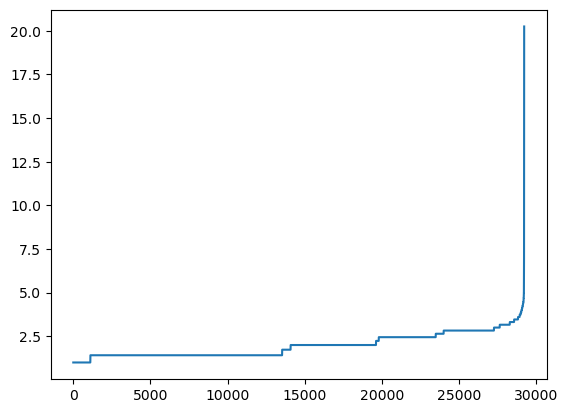

In [ ]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
neigh = NearestNeighbors(n_neighbors=5)
nbrs = neigh.fit(df_cleaned)
distances, indices = nbrs.kneighbors(df_cleaned)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import numpy as np

# Fit DBSCAN model using all features in df_cleaned
dbscan = DBSCAN(eps=4, min_samples=5)
y_pred = dbscan.fit_predict(df_cleaned)

# Print number of clusters and outliers
num_clusters = len(set(y_pred) - {-1})  # Excluding -1 (outliers)
num_outliers = np.sum(y_pred == -1)

print(f'Number of clusters: {num_clusters}')
print(f'Outliers: {num_outliers}')

# Reduce the dimensions to 2D for visualization using PCA
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_cleaned)




Number of clusters: 64
Outliers: 688


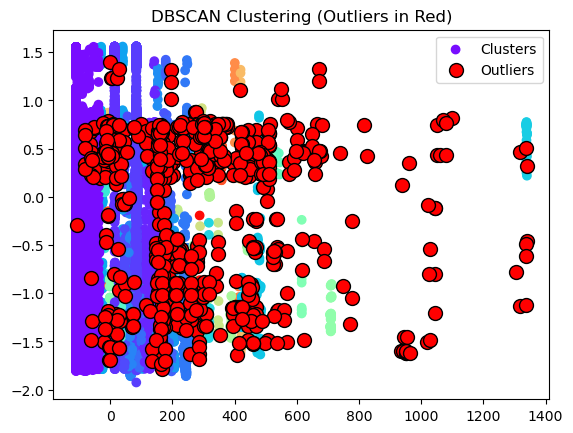

In [ ]:
#scatter Plot
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=y_pred, cmap='rainbow', label='Clusters')
plt.scatter(df_pca[y_pred == -1, 0], df_pca[y_pred == -1, 1], color='red', s=100, label='Outliers', edgecolors='black')
plt.title("DBSCAN Clustering (Outliers in Red)")
plt.legend()
plt.show()

silhouette_score

In [ ]:
from sklearn.metrics import silhouette_score
score = silhouette_score(df_cleaned, dbscan.labels_)
print(f"Silhouette Score: {score}")


Silhouette Score: 0.2233097197031827


tuning model

Number of clusters: 41
Outliers: 228


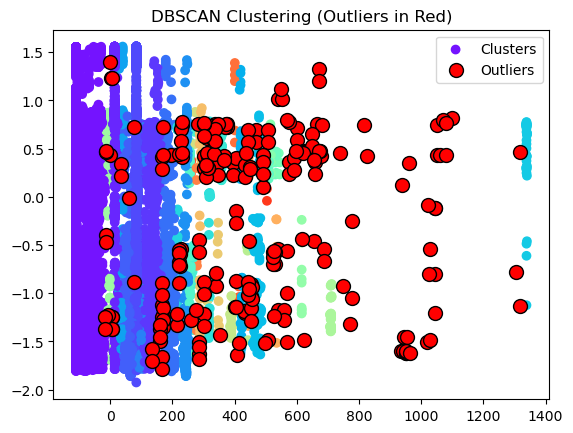

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import numpy as np

# Fit DBSCAN model using all features in df_cleaned
dbscan = DBSCAN(eps=4.5, min_samples=5)
y_pred = dbscan.fit_predict(df_cleaned)

# Print number of clusters and outliers
num_clusters = len(set(y_pred) - {-1})  # Excluding -1 (outliers)
num_outliers = np.sum(y_pred == -1)

print(f'Number of clusters: {num_clusters}')
print(f'Outliers: {num_outliers}')

# Reduce the dimensions to 2D for visualization using PCA
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_cleaned)

#Scatter plot
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=y_pred, cmap='rainbow', label='Clusters')
plt.scatter(df_pca[y_pred == -1, 0], df_pca[y_pred == -1, 1], color='red', s=100, label='Outliers', edgecolors='black')
plt.title("DBSCAN Clustering (Outliers in Red)")
plt.legend()
plt.show()


In [ ]:
#silhouette_score
score = silhouette_score(df_cleaned, dbscan.labels_)
print(f"Silhouette Score: {score}")

Silhouette Score: 0.5490053096915954


Number of clusters: 57
Outliers: 575


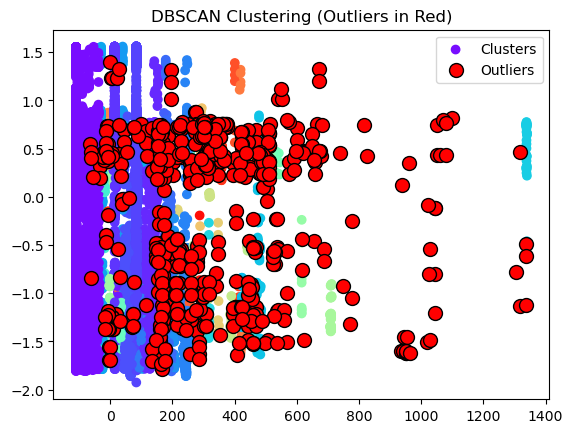

In [ ]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import numpy as np

# Fit DBSCAN model
dbscan = DBSCAN(eps=4.2, min_samples=5)
y_pred = dbscan.fit_predict(df_cleaned)

# Print number of clusters and outliers
num_clusters = len(set(y_pred) - {-1})  # Excluding -1 (outliers)
num_outliers = np.sum(y_pred == -1)

print(f'Number of clusters: {num_clusters}')
print(f'Outliers: {num_outliers}')

# Scatter plot
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=y_pred, cmap='rainbow', label='Clusters')
plt.scatter(df_pca[y_pred == -1, 0], df_pca[y_pred == -1, 1], color='red', s=100, label='Outliers', edgecolors='black')
plt.title("DBSCAN Clustering (Outliers in Red)")
plt.legend()
plt.show()

In [ ]:
#silhouette_score
score = silhouette_score(df_cleaned, dbscan.labels_)
print(f"Silhouette Score: {score}")

Silhouette Score: 0.3776715590171772


# 2. Isolation Forest

In [ ]:
from sklearn.ensemble import IsolationForest


In [ ]:
# Create and fit the model
iso_forest = IsolationForest(contamination=0.1, random_state=42)  # contamination is the expected fraction of outliers
df_cleaned['anomaly'] = iso_forest.fit_predict(df_cleaned)

# The output labels: 1 means normal, -1 means an anomaly (outlier)


In [ ]:
# Identify outliers (labeled as -1 in Isolation Forest)
outliers_if = df_cleaned[df_cleaned['anomaly'] == -1]

# Print outlier data points (attributes)
print(outliers_if)



          3wh    vpn    tor  encrypted  size  timeout  source_ip_1.0.254.69  \
131      True  False  False       True    45    False                 False   
134      True  False  False      False     0    False                 False   
250      True  False  False       True    45    False                 False   
634      True  False  False      False     0    False                 False   
754      True  False  False      False   137    False                 False   
...       ...    ...    ...        ...   ...      ...                   ...   
159476  False  False  False      False   103    False                 False   
159477   True  False  False      False     0    False                 False   
159542   True  False  False       True    41    False                 False   
159544   True  False  False      False     0    False                 False   
159545   True  False  False      False    51    False                 False   

        source_ip_1.1.227.13  source_ip_1.1.229.82 

In [ ]:
anomaly_counts = df_cleaned['anomaly'].value_counts()
print(anomaly_counts)

anomaly
 1    17379
-1     1931
Name: count, dtype: int64


In [ ]:
print(f"Anomalies: {sum(df_cleaned['anomaly'] == -1)} / {len(df_cleaned)}")

Anomalies: 1931 / 19310


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import IsolationForest
from sklearn.metrics import make_scorer
import numpy as np

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': [0.5, 0.75, 1.0],
    'contamination': [0.05, 0.1, 0.2]  # Percentage of anomalies expected
}

# Initialize Isolation Forest
iso_forest = IsolationForest(random_state=42)

# Define a custom scoring function (higher is better)
def anomaly_score(estimator, X):
    scores = estimator.decision_function(X)  # Anomaly scores
    return np.mean(scores)  # Higher means better normal separation

scorer = make_scorer(anomaly_score, greater_is_better=True)

# Perform Grid Search
grid_search = GridSearchCV(iso_forest, param_grid, scoring=scorer, cv=3, n_jobs=-1)

# Fit the model
grid_search.fit(df_cleaned)

# Get best parameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")


D:\anaconda\Lib\site-packages\sklearn\model_selection\_search.py:1102: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best Parameters: {'contamination': 0.05, 'max_features': 0.5, 'n_estimators': 100}


          3wh    vpn    tor  encrypted  size  timeout  source_ip_1.0.254.69  \
0        True  False  False      False    43    False                 False   
42       True  False  False      False   137    False                 False   
134      True  False  False      False     0    False                 False   
156      True  False  False      False     0    False                 False   
530     False  False  False      False   249    False                 False   
...       ...    ...    ...        ...   ...      ...                   ...   
157687   True  False  False      False   126    False                 False   
157763   True  False  False      False   193    False                 False   
158464   True  False  False      False    84    False                 False   
158669   True  False  False      False     0    False                 False   
159131   True  False  False      False     0    False                 False   

        source_ip_1.1.227.13  source_ip_1.1.229.82 

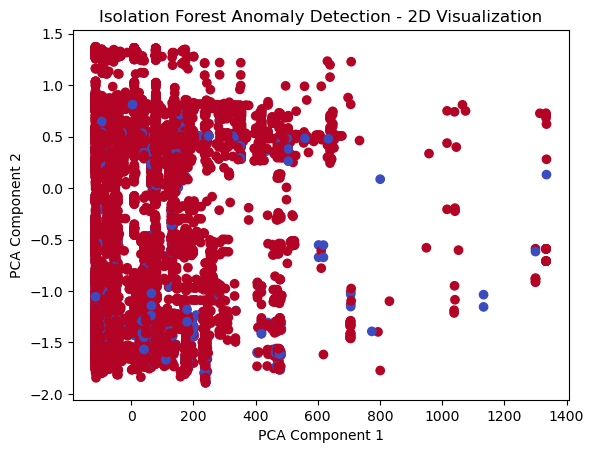

In [ ]:

from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Fit Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42, max_features=0.5, max_samples='auto', n_estimators=100)
df_cleaned['anomaly'] = iso_forest.fit_predict(df_cleaned)

# Identify outliers (labeled as -1 in Isolation Forest)
outliers_if = df_cleaned[df_cleaned['anomaly'] == -1]

# Print outlier data points (attributes)
print(outliers_if)

# Print anomaly counts
anomaly_counts = df_cleaned['anomaly'].value_counts()
print(anomaly_counts)

# Print anomaly ratio
print(f"Anomalies: {sum(df_cleaned['anomaly'] == -1)} / {len(df_cleaned)}")

# Convert anomaly labels (1 for normal, 0 for anomalies) for silhouette scoring
labels = [0 if label == -1 else 1 for label in df_cleaned['anomaly']]

# Compute the Silhouette Coefficient
score = silhouette_score(df_cleaned.drop(columns=['anomaly']), labels)  # Dropping 'anomaly' column for features
print(f"Silhouette Score: {score}")

# Visualize the clusters in 2D using PCA
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(df_cleaned.drop(columns=['anomaly']))

# Scatter plot of 2D representation of the data points
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap='coolwarm')
plt.title("Isolation Forest Anomaly Detection - 2D Visualization")
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


3. one class svm

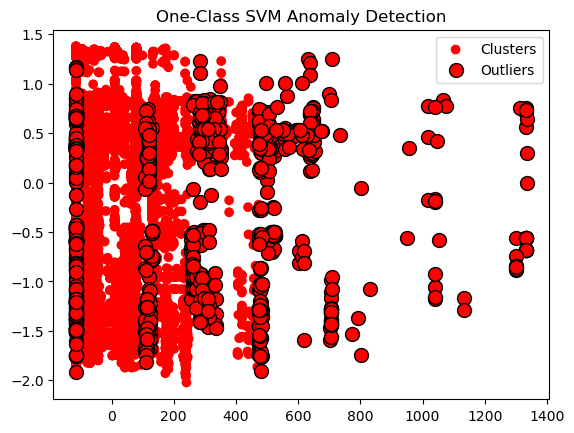

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM

# Train One-Class SVM
oc_svm = OneClassSVM(kernel='rbf', nu=0.05, gamma='scale')
y_pred = oc_svm.fit_predict(df_cleaned)  # Predictions (-1 = anomaly, 1 = normal)


# Reduce the dimensions to 2D for visualization using PCA
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_cleaned)

# Visualize results
#scatter Plot
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=y_pred, cmap='rainbow', label='Clusters')
plt.scatter(df_pca[y_pred == -1, 0], df_pca[y_pred == -1, 1], color='red', s=100, label='Outliers', edgecolors='black')
plt.title("One-Class SVM Anomaly Detection")
plt.legend()
plt.show()



In [ ]:
from sklearn.metrics import silhouette_score

# Compute Silhouette Score (only for clustered data)
silhouette = silhouette_score(df_cleaned, y_pred)
print(f"Silhouette Score: {silhouette:.4f}")


Silhouette Score: 0.6058
